# Neccessary Import Statements

In [1]:
# Allows for changes made to scripts in src to be included in the work
# done in this notebook.
%load_ext autoreload
%autoreload 2

In [2]:
# file access
import os
import joblib
notebook_dir = os.getcwd()

In [3]:
# data manipulation
import pandas as pd
import dask.dataframe as dd
import numpy as np
import swifter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

# ML-related packages
from sklearn.model_selection import train_test_split

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

# custom modules 
from src.data import common_tasks as ct
from src.data import feature_engineering as fe
from src.data import data_loader as dl
from src.models import clustering as clus
from src.visualizations import cluster_bar_chart_prep as cbcp
from src.visualizations import basic_viz as bv

<Figure size 432x288 with 0 Axes>

# Add a Score Column to the Raw Tracking Data

In [4]:
full_df = ct.EVENTS_DF

In [5]:
full_df.tail()

eventId           subEventName  \
3251289        5  Ball out of the field   
3251290        3                 Corner   
3251291        1               Air duel   
3251292        1               Air duel   
3251293       10                   Shot   

                                                      tags  playerId  \
3251289                                                 []         0   
3251290           [{'id': 302}, {'id': 801}, {'id': 1801}]     70965   
3251291                        [{'id': 701}, {'id': 1802}]      7919   
3251292                        [{'id': 703}, {'id': 1801}]      8005   
3251293  [{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...      8005   

                                          positions  matchId     eventName  \
3251289   [{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]  2500098  Interruption   
3251290  [{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]  2500098     Free Kick   
3251291    [{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]  2500098          Duel   
3251292    [{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]  2500098          Duel   
3251293      [{'y': 50, 'x': 86}, {'y': 0, 'x': 0}]  2500098          Shot   

         teamId matchPeriod     eventSec subEventId         id  
3251289    1623          2H  2796.732525         50  251596409  
3251290    1633          2H  2829.821084         30  251596232  
3251291    1623          2H  2831.211419         10  251596410  
3251292    1633          2H  2832.434399         10  251596234  
3251293    1633          2H  2834.127168        100  251596236

### Following Code Actually Gets Column. Only Run If Data Is Not Already Saved

In [ ]:
scores_full_series = ct.score_compiler(events_data=full_df)
full_df["score"] = scores_full_series

In [ ]:
full_df.tail()

In [ ]:
### ONLY RUN CELL IF YOU WOULD LIKE TO SAVE THIS DATAFRAME ### 
score_rel_dir = "../data/interim"
score_dir = os.path.join(notebook_dir, score_rel_dir)

full_df.to_csv("{}/events_with_scores.csv".format(score_dir))

### Only run following cells if the new dataframe with the score column has been saved

In [6]:
### ONLY RUN CELL IF YOU LIKE TO LOAD IN THIS DATAFRAME ###
score_rel_dir = "../data/interim"
score_dir = os.path.join(notebook_dir, score_rel_dir)

full_df = pd.read_csv(
    "{}/events_with_scores.csv".format(score_dir)
).drop(columns=["Unnamed: 0"])

In [7]:
full_df.tail()

eventId           subEventName  \
3251289        5  Ball out of the field   
3251290        3                 Corner   
3251291        1               Air duel   
3251292        1               Air duel   
3251293       10                   Shot   

                                                      tags  playerId  \
3251289                                                 []         0   
3251290           [{'id': 302}, {'id': 801}, {'id': 1801}]     70965   
3251291                        [{'id': 701}, {'id': 1802}]      7919   
3251292                        [{'id': 703}, {'id': 1801}]      8005   
3251293  [{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...      8005   

                                          positions  matchId     eventName  \
3251289   [{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]  2500098  Interruption   
3251290  [{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]  2500098     Free Kick   
3251291    [{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]  2500098          Duel   
3251292    [{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]  2500098          Duel   
3251293      [{'y': 50, 'x': 86}, {'y': 0, 'x': 0}]  2500098          Shot   

         teamId matchPeriod     eventSec  subEventId         id score  
3251289    1623          2H  2796.732525        50.0  251596409   1-1  
3251290    1633          2H  2829.821084        30.0  251596232   1-1  
3251291    1623          2H  2831.211419        10.0  251596410   1-1  
3251292    1633          2H  2832.434399        10.0  251596234   1-1  
3251293    1633          2H  2834.127168       100.0  251596236   1-1

# Join With Sequence Data

### First, load in that sequence data and wrangle it (only run if data is NOT saved)

In [9]:
sequences_df = dl.sequence_data(with_scores=False)
sequences_df

eventId           subEventName  \
0              3              Free Kick   
1              8            Simple pass   
2              8            Simple pass   
3              8            Simple pass   
4              8            Simple pass   
...          ...                    ...   
1891129        8                  Cross   
1891130        7              Clearance   
1891131        5  Ball out of the field   
1891132        3                 Corner   
1891133        7              Clearance   

                                             tags  playerId  \
0                                  [{'id': 1801}]         0   
1                                  [{'id': 1801}]     50007   
2                                  [{'id': 1801}]     24838   
3                                  [{'id': 1801}]     21415   
4                                  [{'id': 1801}]    284960   
...                                           ...       ...   
1891129  [{'id': 402}, {'id': 801}, {'id': 1802}]    341973   
1891130              [{'id': 1401}, {'id': 1802}]     28529   
1891131                                        []         0   
1891132               [{'id': 801}, {'id': 1802}]    244335   
1891133              [{'id': 1401}, {'id': 1802}]    410062   

                                        positions  matchId  \
0        [{'y': 64, 'x': 35}, {'y': 31, 'x': 38}]  2576040   
1        [{'y': 31, 'x': 38}, {'y': 20, 'x': 38}]  2576040   
2        [{'y': 20, 'x': 38}, {'y': 50, 'x': 27}]  2576040   
3        [{'y': 50, 'x': 27}, {'y': 77, 'x': 32}]  2576040   
4        [{'y': 77, 'x': 32}, {'y': 95, 'x': 36}]  2576040   
...                                           ...      ...   
1891129  [{'y': 72, 'x': 96}, {'y': 38, 'x': 96}]  2501010   
1891130    [{'y': 62, 'x': 4}, {'y': 64, 'x': 0}]  2501010   
1891131   [{'y': 36, 'x': 100}, {'y': 0, 'x': 0}]  2501010   
1891132  [{'y': 0, 'x': 100}, {'y': 45, 'x': 89}]  2501010   
1891133  [{'y': 55, 'x': 11}, {'y': 64, 'x': 26}]  2501010   

                  eventName  teamId matchPeriod     eventSec subEventId  \
0                 Free Kick    3219          2H  2216.339790         31   
1                      Pass    3219          2H  2221.716912         85   
2                      Pass    3219          2H  2225.150837         85   
3                      Pass    3219          2H  2228.885593         85   
4                      Pass    3219          2H  2231.951066         85   
...                     ...     ...         ...          ...        ...   
1891129                Pass    3787          2H  1662.199741         80   
1891130  Others on the ball    3772          2H  1664.021805         71   
1891131        Interruption    3787          2H  1670.963763         50   
1891132           Free Kick    3787          2H  1685.122411         30   
1891133  Others on the ball    3772          2H  1686.592945         71   

                id  seq_id  
0        198792553     100  
1        198792554     100  
2        198792555     100  
3        198792556     100  
4        198792557     100  
...            ...     ...  
1891129  243183546  275429  
1891130  243183126  275429  
1891131  243183547  275429  
1891132  243183548  275430  
1891133  243183127  275430  

[1891134 rows x 13 columns]

Evidently, the assignment of a sequence ID (see `seq_id` column) did not go according to plan as we seperated the data into three different files. Thus, we will clean up that column here. We do this by taking advantage of the fact that each set piece sequence begins with a value for the `eventId` column of 3.

In [10]:
indicies_of_sequence_starts = np.argwhere(
    (sequences_df.eventId == 3).to_numpy()
).flatten()
indicies_of_sequence_starts

array([      0,       7,      11, ..., 1891117, 1891120, 1891132])

In [11]:
sp_sequence_ids_list = []
last_start = 0
current_id = 100
for index in indicies_of_sequence_starts:
    # First, update values for all of the events that make up the sequence
    # whose beginning row index we are now working with during this iteration.
    if last_start != index:
        sp_sequence_ids_list += [current_id]*(index-last_start)
    
        # Update necessary values
        current_id += 1
        last_start = index + 1
        
        sp_sequence_ids_list.append(current_id)
        assert len(sp_sequence_ids_list) == index + 1

# Fill in the values 
sp_sequence_ids_list += [current_id]*(
    sequences_df.shape[0]-len(sp_sequence_ids_list))

assert len(sp_sequence_ids_list) == sequences_df.shape[0]

In [12]:
sequences_df.drop(columns="seq_id", inplace=True) 
sequences_df["seq_id"] = pd.Series(sp_sequence_ids_list)
sequences_df

eventId           subEventName  \
0              3              Free Kick   
1              8            Simple pass   
2              8            Simple pass   
3              8            Simple pass   
4              8            Simple pass   
...          ...                    ...   
1891129        8                  Cross   
1891130        7              Clearance   
1891131        5  Ball out of the field   
1891132        3                 Corner   
1891133        7              Clearance   

                                             tags  playerId  \
0                                  [{'id': 1801}]         0   
1                                  [{'id': 1801}]     50007   
2                                  [{'id': 1801}]     24838   
3                                  [{'id': 1801}]     21415   
4                                  [{'id': 1801}]    284960   
...                                           ...       ...   
1891129  [{'id': 402}, {'id': 801}, {'id': 1802}]    341973   
1891130              [{'id': 1401}, {'id': 1802}]     28529   
1891131                                        []         0   
1891132               [{'id': 801}, {'id': 1802}]    244335   
1891133              [{'id': 1401}, {'id': 1802}]    410062   

                                        positions  matchId  \
0        [{'y': 64, 'x': 35}, {'y': 31, 'x': 38}]  2576040   
1        [{'y': 31, 'x': 38}, {'y': 20, 'x': 38}]  2576040   
2        [{'y': 20, 'x': 38}, {'y': 50, 'x': 27}]  2576040   
3        [{'y': 50, 'x': 27}, {'y': 77, 'x': 32}]  2576040   
4        [{'y': 77, 'x': 32}, {'y': 95, 'x': 36}]  2576040   
...                                           ...      ...   
1891129  [{'y': 72, 'x': 96}, {'y': 38, 'x': 96}]  2501010   
1891130    [{'y': 62, 'x': 4}, {'y': 64, 'x': 0}]  2501010   
1891131   [{'y': 36, 'x': 100}, {'y': 0, 'x': 0}]  2501010   
1891132  [{'y': 0, 'x': 100}, {'y': 45, 'x': 89}]  2501010   
1891133  [{'y': 55, 'x': 11}, {'y': 64, 'x': 26}]  2501010   

                  eventName  teamId matchPeriod     eventSec subEventId  \
0                 Free Kick    3219          2H  2216.339790         31   
1                      Pass    3219          2H  2221.716912         85   
2                      Pass    3219          2H  2225.150837         85   
3                      Pass    3219          2H  2228.885593         85   
4                      Pass    3219          2H  2231.951066         85   
...                     ...     ...         ...          ...        ...   
1891129                Pass    3787          2H  1662.199741         80   
1891130  Others on the ball    3772          2H  1664.021805         71   
1891131        Interruption    3787          2H  1670.963763         50   
1891132           Free Kick    3787          2H  1685.122411         30   
1891133  Others on the ball    3772          2H  1686.592945         71   

                id  seq_id  
0        198792553     100  
1        198792554     100  
2        198792555     100  
3        198792556     100  
4        198792557     100  
...            ...     ...  
1891129  243183546  275429  
1891130  243183126  275429  
1891131  243183547  275429  
1891132  243183548  275430  
1891133  243183127  275430  

[1891134 rows x 13 columns]

### Now we are ready for the join (only run if data is NOT saved)

In [13]:
# see https://stackoverflow.com/questions/40860457/improve-pandas-merge-performance
# for the trick used to speed up this join.
sequences_with_scores_df = sequences_df.set_index("id").merge(
    right=full_df[["score", "id"]].set_index("id"), 
    how="left", 
    left_index=True, 
    right_index=True
).sort_values(by=["seq_id", "eventSec"]).reset_index(drop=False)

In [14]:
sequences_with_scores_df.head(n=15)

id  eventId           subEventName                         tags  \
0   198792553        3              Free Kick               [{'id': 1801}]   
1   198792554        8            Simple pass               [{'id': 1801}]   
2   198792555        8            Simple pass               [{'id': 1801}]   
3   198792556        8            Simple pass               [{'id': 1801}]   
4   198792557        8            Simple pass               [{'id': 1801}]   
5   198792558        8            Simple pass               [{'id': 1802}]   
6   198792413        7                  Touch               [{'id': 1401}]   
7   198792422        3               Throw in               [{'id': 1801}]   
8   198792424        8              Head pass               [{'id': 1801}]   
9   198792426        1  Ground attacking duel  [{'id': 702}, {'id': 1801}]   
10  198792581        1  Ground defending duel  [{'id': 702}, {'id': 1801}]   
11  198792438        3              Free Kick               [{'id': 1801}]   
12  198792439        8            Simple pass               [{'id': 1801}]   
13  198792441        8            Simple pass               [{'id': 1801}]   
14  198792443        8            Simple pass               [{'id': 1801}]   

    playerId                                  positions  matchId  \
0          0   [{'y': 64, 'x': 35}, {'y': 31, 'x': 38}]  2576040   
1      50007   [{'y': 31, 'x': 38}, {'y': 20, 'x': 38}]  2576040   
2      24838   [{'y': 20, 'x': 38}, {'y': 50, 'x': 27}]  2576040   
3      21415   [{'y': 50, 'x': 27}, {'y': 77, 'x': 32}]  2576040   
4     284960   [{'y': 77, 'x': 32}, {'y': 95, 'x': 36}]  2576040   
5     402017   [{'y': 95, 'x': 36}, {'y': 97, 'x': 34}]  2576040   
6     116170     [{'y': 3, 'x': 66}, {'y': 2, 'x': 73}]  2576040   
7      22313  [{'y': 100, 'x': 21}, {'y': 89, 'x': 35}]  2576040   
8      20663   [{'y': 89, 'x': 35}, {'y': 92, 'x': 45}]  2576040   
9     368340   [{'y': 92, 'x': 45}, {'y': 94, 'x': 43}]  2576040   
10     50007     [{'y': 8, 'x': 55}, {'y': 6, 'x': 57}]  2576040   
11     22380   [{'y': 87, 'x': 45}, {'y': 74, 'x': 23}]  2576040   
12     86328   [{'y': 74, 'x': 23}, {'y': 39, 'x': 26}]  2576040   
13     20866   [{'y': 39, 'x': 26}, {'y': 34, 'x': 40}]  2576040   
14    116170   [{'y': 34, 'x': 40}, {'y': 77, 'x': 40}]  2576040   

             eventName  teamId matchPeriod     eventSec subEventId  seq_id  \
0            Free Kick    3219          2H  2216.339790         31     100   
1                 Pass    3219          2H  2221.716912         85     100   
2                 Pass    3219          2H  2225.150837         85     100   
3                 Pass    3219          2H  2228.885593         85     100   
4                 Pass    3219          2H  2231.951066         85     100   
5                 Pass    3219          2H  2234.294645         85     100   
6   Others on the ball    3176          2H  2234.910022         72     100   
7            Free Kick    3176          2H  2323.110192         36     101   
8                 Pass    3176          2H  2325.343165         82     101   
9                 Duel    3176          2H  2327.161051         11     101   
10                Duel    3219          2H  2327.161051         12     101   
11           Free Kick    3176          2H  2349.333198         31     102   
12                Pass    3176          2H  2352.283761         85     102   
13                Pass    3176          2H  2355.288237         85     102   
14                Pass    3176          2H  2358.217890         85     102   

   score  
0    0-1  
1    0-1  
2    0-1  
3    0-1  
4    0-1  
5    0-1  
6    0-1  
7    0-1  
8    0-1  
9    0-1  
10   0-1  
11   0-1  
12   0-1  
13   0-1  
14   0-1

In [15]:
sequences_with_scores_df.tail(n=15)

id  eventId           subEventName  \
1891119  210903062        1               Air duel   
1891120  243183540        3               Throw in   
1891121  243183541        8            Simple pass   
1891122  243183542        8            Simple pass   
1891123  243183543        1  Ground attacking duel   
1891124  243184142        1  Ground defending duel   
1891125  243183544       10                   Shot   
1891126  243183124        7                  Touch   
1891127  243183125        8              Head pass   
1891128  243183545        8              High pass   
1891129  243183546        8                  Cross   
1891130  243183126        7              Clearance   
1891131  243183547        5  Ball out of the field   
1891132  243183548        3                 Corner   
1891133  243183127        7              Clearance   

                                              tags  playerId  \
1891119                [{'id': 703}, {'id': 1801}]      3568   
1891120                             [{'id': 1801}]    143189   
1891121                             [{'id': 1801}]    341973   
1891122                             [{'id': 1801}]     25829   
1891123   [{'id': 502}, {'id': 703}, {'id': 1801}]    341973   
1891124   [{'id': 501}, {'id': 701}, {'id': 1802}]         0   
1891125  [{'id': 401}, {'id': 2101}, {'id': 1802}]    341973   
1891126                             [{'id': 1401}]     14717   
1891127                             [{'id': 1802}]     28529   
1891128                             [{'id': 1801}]    246946   
1891129   [{'id': 402}, {'id': 801}, {'id': 1802}]    341973   
1891130               [{'id': 1401}, {'id': 1802}]     28529   
1891131                                         []         0   
1891132                [{'id': 801}, {'id': 1802}]    244335   
1891133               [{'id': 1401}, {'id': 1802}]    410062   

                                         positions  matchId  \
1891119   [{'y': 80, 'x': 40}, {'y': 94, 'x': 69}]  2565679   
1891120  [{'y': 100, 'x': 88}, {'y': 80, 'x': 81}]  2501010   
1891121   [{'y': 80, 'x': 81}, {'y': 75, 'x': 76}]  2501010   
1891122   [{'y': 75, 'x': 76}, {'y': 74, 'x': 83}]  2501010   
1891123   [{'y': 74, 'x': 83}, {'y': 73, 'x': 83}]  2501010   
1891124   [{'y': 26, 'x': 17}, {'y': 27, 'x': 17}]  2501010   
1891125     [{'y': 73, 'x': 83}, {'y': 0, 'x': 0}]  2501010   
1891126   [{'y': 29, 'x': 10}, {'y': 61, 'x': 14}]  2501010   
1891127   [{'y': 61, 'x': 14}, {'y': 54, 'x': 28}]  2501010   
1891128   [{'y': 46, 'x': 72}, {'y': 72, 'x': 96}]  2501010   
1891129   [{'y': 72, 'x': 96}, {'y': 38, 'x': 96}]  2501010   
1891130     [{'y': 62, 'x': 4}, {'y': 64, 'x': 0}]  2501010   
1891131    [{'y': 36, 'x': 100}, {'y': 0, 'x': 0}]  2501010   
1891132   [{'y': 0, 'x': 100}, {'y': 45, 'x': 89}]  2501010   
1891133   [{'y': 55, 'x': 11}, {'y': 64, 'x': 26}]  2501010   

                  eventName  teamId matchPeriod     eventSec subEventId  \
1891119                Duel     683          2H  1110.286973         10   
1891120           Free Kick    3787          2H  1643.482051         36   
1891121                Pass    3787          2H  1646.104702         85   
1891122                Pass    3787          2H  1651.253875         85   
1891123                Duel    3787          2H  1653.463764         11   
1891124                Duel    3772          2H  1653.463764         12   
1891125                Shot    3787          2H  1654.285870        100   
1891126  Others on the ball    3772          2H  1656.165901         72   
1891127                Pass    3772          2H  1657.703004         82   
1891128                Pass    3787          2H  1660.835180         83   
1891129                Pass    3787          2H  1662.199741         80   
1891130  Others on the ball    3772          2H  1664.021805         71   
1891131        Interruption    3787          2H  1670.963763         50   
1891132           Free Kick    3787          2H  1685.122411       

In [16]:
### ONLY RUN THIS CELL IF YOU WISH TO SAVE THIS DATAFRAME ###
seq_with_scores_rel_dir = "../data/interim"
seq_with_scores_dir = os.path.join(notebook_dir, seq_with_scores_rel_dir)

sequences_with_scores_df.to_csv("{}/sequences_with_scores.csv".format(seq_with_scores_dir))

### Load in sequence data with scores (only run if data IS saved)

In [17]:
sequences_with_scores_df = dl.sequence_data()
sequences_with_scores_df

id  eventId           subEventName  \
0        198792553        3              Free Kick   
1        198792554        8            Simple pass   
2        198792555        8            Simple pass   
3        198792556        8            Simple pass   
4        198792557        8            Simple pass   
...            ...      ...                    ...   
1891129  243183546        8                  Cross   
1891130  243183126        7              Clearance   
1891131  243183547        5  Ball out of the field   
1891132  243183548        3                 Corner   
1891133  243183127        7              Clearance   

                                             tags  playerId  \
0                                  [{'id': 1801}]         0   
1                                  [{'id': 1801}]     50007   
2                                  [{'id': 1801}]     24838   
3                                  [{'id': 1801}]     21415   
4                                  [{'id': 1801}]    284960   
...                                           ...       ...   
1891129  [{'id': 402}, {'id': 801}, {'id': 1802}]    341973   
1891130              [{'id': 1401}, {'id': 1802}]     28529   
1891131                                        []         0   
1891132               [{'id': 801}, {'id': 1802}]    244335   
1891133              [{'id': 1401}, {'id': 1802}]    410062   

                                        positions  matchId  \
0        [{'y': 64, 'x': 35}, {'y': 31, 'x': 38}]  2576040   
1        [{'y': 31, 'x': 38}, {'y': 20, 'x': 38}]  2576040   
2        [{'y': 20, 'x': 38}, {'y': 50, 'x': 27}]  2576040   
3        [{'y': 50, 'x': 27}, {'y': 77, 'x': 32}]  2576040   
4        [{'y': 77, 'x': 32}, {'y': 95, 'x': 36}]  2576040   
...                                           ...      ...   
1891129  [{'y': 72, 'x': 96}, {'y': 38, 'x': 96}]  2501010   
1891130    [{'y': 62, 'x': 4}, {'y': 64, 'x': 0}]  2501010   
1891131   [{'y': 36, 'x': 100}, {'y': 0, 'x': 0}]  2501010   
1891132  [{'y': 0, 'x': 100}, {'y': 45, 'x': 89}]  2501010   
1891133  [{'y': 55, 'x': 11}, {'y': 64, 'x': 26}]  2501010   

                  eventName  teamId matchPeriod     eventSec  subEventId  \
0                 Free Kick    3219          2H  2216.339790        31.0   
1                      Pass    3219          2H  2221.716912        85.0   
2                      Pass    3219          2H  2225.150837        85.0   
3                      Pass    3219          2H  2228.885593        85.0   
4                      Pass    3219          2H  2231.951066        85.0   
...                     ...     ...         ...          ...         ...   
1891129                Pass    3787          2H  1662.199741        80.0   
1891130  Others on the ball    3772          2H  1664.021805        71.0   
1891131        Interruption    3787          2H  1670.963763        50.0   
1891132           Free Kick    3787          2H  1685.122411        30.0   
1891133  Others on the ball    3772          2H  1686.592945        71.0   

         seq_id score  
0           100   0-1  
1           100   0-1  
2           100   0-1  
3           100   0-1  
4           100   0-1  
...         ...   ...  
1891129  275429   0-1  
1891130  275429   0-1  
1891131  275429   0-1  
1891132  275430   0-1  
1891133  275430   0-1  

[1891134 rows x 14 columns]

# Compile Engineered Features

### Only run following hidden cells if feature data is NOT saved

In [ ]:
features_df = fe.basic_instance_features(sequences_with_scores_df)

In [ ]:
features_df.head()

In [ ]:
### ONLY RUN THIS IF YOU ARE SAVING THIS DATAFRAME ###
features_rel_dir = "../data/final/initial_clustering"
feature_dir = os.path.join(notebook_dir, features_rel_dir)

features_df.to_csv("{}/init_clust_features.csv".format(feature_dir))

### Only run following cell if feature data IS saved.

In [18]:
### ONLY RUN THIS IF YOU ARE LOADING THIS DATAFRAME ###
features_rel_dir = "../data/final/initial_clustering"
feature_dir = os.path.join(notebook_dir, features_rel_dir)

features_df = pd.read_csv(
    "{}/init_clust_features.csv".format(feature_dir)
).drop(columns=["Unnamed: 0"])
features_df

seq_id         id  matchId  match_time  score_diff  is_goalie  \
0           100  198792553  2576040    1.410433           1          0   
1           100  198792554  2576040    1.411429           1          0   
2           100  198792555  2576040    1.412065           1          0   
3           100  198792556  2576040    1.412757           1          1   
4           100  198792557  2576040    1.413324           1          0   
...         ...        ...      ...         ...         ...        ...   
1891129  275429  243183546  2501010    0.807815           1          0   
1891130  275429  243183126  2501010    0.808152          -1          0   
1891131  275429  243183547  2501010    0.809438           1          0   
1891132  275430  243183548  2501010    0.812060           1          0   
1891133  275430  243183127  2501010    0.812332          -1          0   

         is_mid  is_def  is_foward  pos_delta_diff  to_goal_delta_diff  \
0             0       0          0       33.136083           -1.644629   
1             0       1          0       11.000000            4.030730   
2             0       1          0       31.953091            4.123299   
3             0       0          0       27.459060            0.164199   
4             0       1          0       18.439089            5.072621   
...         ...     ...        ...             ...                 ...   
1891129       0       1          0       34.000000           -9.711569   
1891130       0       1          0        4.472136            4.228152   
1891131       0       0          0      106.282642           97.803399   
1891132       0       0          1       46.324939          -37.916954   
1891133       0       1          0       17.492856          -13.827657   

         num_attacking_events  
0                    1.000000  
1                    1.000000  
2                    1.000000  
3                    1.000000  
4                    1.000000  
...                       ...  
1891129              0.700000  
1891130              0.636364  
1891131              0.666667  
1891132              1.000000  
1891133              0.500000  

[1891134 rows x 12 columns]

### Explore the Result

In [19]:
features_df.score_diff.value_counts()

 0    927804
-1    330594
 1    328775
 2    104265
-2    102308
 3     34925
-3     34850
-4      9947
 4      9283
-5      3520
 5      3351
-6       697
 6       622
-7        55
-8        50
 7        48
 8        40
Name: score_diff, dtype: int64

In [20]:
features_df.is_foward.value_counts()

0    1607056
1     284078
Name: is_foward, dtype: int64

In [21]:
features_df[["pos_delta_diff", "to_goal_delta_diff", "num_attacking_events"]].describe()

pos_delta_diff  to_goal_delta_diff  num_attacking_events
count    1.891134e+06        1.891134e+06          1.891134e+06
mean     2.610758e+01       -3.115176e+00          7.800291e-01
std      2.489531e+01        2.074108e+01          2.600922e-01
min      0.000000e+00       -1.068034e+02          3.703704e-02
25%      9.219544e+00       -1.181963e+01          6.250000e-01
50%      1.835756e+01       -2.284317e+00          8.571429e-01
75%      3.354102e+01        4.546684e+00          1.000000e+00
max      1.414214e+02        1.118034e+02          1.000000e+00

# Scale Engineered Features

In [22]:
features_not_to_scale_arr = features_df[
    ["match_time", "score_diff", "is_goalie", "is_mid", "is_def", "is_foward", "num_attacking_events"]
].to_numpy()
features_not_to_scale_arr.shape

(1891134, 7)

In [23]:
features_not_to_scale_arr[0]

array([1.41043329, 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        ])

In [24]:
features_to_scale_arr = features_df[
    ["pos_delta_diff", "to_goal_delta_diff"]
].to_numpy()
features_to_scale_arr.shape

(1891134, 2)

In [25]:
features_to_scale_arr[0]

array([33.13608305, -1.64462949])

In [26]:
std_scaler = StandardScaler()
scaled_features = std_scaler.fit_transform(X=features_to_scale_arr)
scaled_features.shape

(1891134, 2)

In [27]:
scaled_features[0]

array([0.28232236, 0.0709002 ])

In [28]:
print(scaled_features.mean(axis=0))
print(scaled_features.var(axis=0))

[ 1.03917496e-16 -3.51827114e-17]
[1. 1.]


In [29]:
full_scaled_feats_arr = np.hstack([features_not_to_scale_arr, scaled_features])
full_scaled_feats_arr.shape

(1891134, 9)

In [30]:
full_scaled_feats_arr[0]

array([1.41043329, 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.28232236, 0.0709002 ])

In [32]:
full_unscaled_feats_arr = features_df.drop(
    columns=["seq_id", "id", "matchId"]).to_numpy()
full_unscaled_feats_arr.shape

(1891134, 9)

Thus, the order of the features going left-to-right in the columns is `match_time`, `score_diff`, `is_goalie`, `is_mid`, `is_def`, `is_foward`, `num_attacking_events`, `pos_delta_diff`, and `to_goal_delta_diff` with the latter two being scaled so that their mean is 0 and their variance is one.

# Create Sequence-Wide Features

In [33]:
grouped_by_seq_df = features_df.groupby("seq_id")

In [34]:
aggregated_by_mean_df = grouped_by_seq_df.mean().drop(columns=["id", "matchId"])
aggregated_by_mean_df

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
seq_id                                                                     
100       1.412520    0.714286   0.142857  0.142857  0.571429   0.000000   
101       1.430684   -0.500000   0.000000  0.000000  0.500000   0.500000   
102       1.436421   -0.666667   0.000000  0.333333  0.666667   0.000000   
103       1.445103    0.777778   0.000000  0.555556  0.222222   0.111111   
104       1.450213    1.000000   0.000000  0.250000  0.250000   0.500000   
...            ...         ...        ...       ...       ...        ...   
275426    0.921815    0.111111   0.000000  0.333333  0.500000   0.111111   
275427    0.987549    1.000000   0.000000  0.200000  0.200000   0.600000   
275428    0.705332    0.000000   0.333333  0.666667  0.000000   0.000000   
275429    0.806697    0.333333   0.000000  0.166667  0.583333   0.083333   
275430    0.812196    0.000000   0.000000  0.000000  0.500000   0.500000   

        pos_delta_diff  to_goal_delta_diff  num_attacking_events  
seq_id                                                            
100          18.840974            1.656878              0.979592  
101           8.475414           -5.379718              0.937500  
102          25.822264           -4.729189              0.972222  
103          15.897360           -3.819662              0.987654  
104          43.733520           13.975425              1.000000  
...                ...                 ...                   ...  
275426       25.079667           -1.170050              0.946789  
275427       25.789828          -14.007084              1.000000  
275428       51.282563            6.192316              0.888889  
275429       31.325560           10.516752              0.803526  
275430       31.908897          -25.872306              0.750000  

[275331 rows x 9 columns]

In [35]:
aggregated_by_mean_df["delta_max_avg"] = grouped_by_seq_df.max()[
    ["pos_delta_diff", "to_goal_delta_diff"]
].mean(axis=1)
aggregated_by_mean_df

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
seq_id                                                                     
100       1.412520    0.714286   0.142857  0.142857  0.571429   0.000000   
101       1.430684   -0.500000   0.000000  0.000000  0.500000   0.500000   
102       1.436421   -0.666667   0.000000  0.333333  0.666667   0.000000   
103       1.445103    0.777778   0.000000  0.555556  0.222222   0.111111   
104       1.450213    1.000000   0.000000  0.250000  0.250000   0.500000   
...            ...         ...        ...       ...       ...        ...   
275426    0.921815    0.111111   0.000000  0.333333  0.500000   0.111111   
275427    0.987549    1.000000   0.000000  0.200000  0.200000   0.600000   
275428    0.705332    0.000000   0.333333  0.666667  0.000000   0.000000   
275429    0.806697    0.333333   0.000000  0.166667  0.583333   0.083333   
275430    0.812196    0.000000   0.000000  0.000000  0.500000   0.500000   

        pos_delta_diff  to_goal_delta_diff  num_attacking_events  \
seq_id                                                             
100          18.840974            1.656878              0.979592   
101           8.475414           -5.379718              0.937500   
102          25.822264           -4.729189              0.972222   
103          15.897360           -3.819662              0.987654   
104          43.733520           13.975425              1.000000   
...                ...                 ...                   ...   
275426       25.079667           -1.170050              0.946789   
275427       25.789828          -14.007084              1.000000   
275428       51.282563            6.192316              0.888889   
275429       31.325560           10.516752              0.803526   
275430       31.908897          -25.872306              0.750000   

        delta_max_avg  
seq_id                 
100         19.104352  
101         10.304418  
102         28.683163  
103         19.215507  
104         91.612739  
...               ...  
275426      75.546815  
275427      30.094409  
275428      60.638960  
275429     104.169231  
275430      16.248641  

[275331 rows x 10 columns]

In [36]:
aggregated_by_mean_arr = aggregated_by_mean_df.to_numpy()
aggregated_by_mean_arr.shape

(275331, 10)

In [38]:
scaled = std_scaler.fit_transform(aggregated_by_mean_arr[:,[-4, -3, -1]])

In [39]:
scaled.shape

(275331, 3)

In [40]:
agg_by_mean_scaled_arr = np.hstack(
    [aggregated_by_mean_arr.T[0:-4:].T,
     scaled[:,[0, 1]],
     aggregated_by_mean_arr[:,-2].reshape(-1, 1),
     scaled[:,-1].reshape(-1, 1)]
)
agg_by_mean_scaled_arr.shape

(275331, 10)

In [41]:
print(scaled[0], end="\n\n\n")
print(agg_by_mean_scaled_arr[0])

[-0.61372447  0.46074248 -0.85047775]


[ 1.41251981  0.71428571  0.14285714  0.14285714  0.57142857  0.
 -0.61372447  0.46074248  0.97959184 -0.85047775]


Evidently, the order of features for the aggregated data is `match_time`, `score_diff`, `is_goalie`, `is_mid`, `is_def`, `is_foward`, `pos_delta_diff`, `to_goal_delta_diff`,  `num_attacking_events`, and  `delta_max_avg`

# Fit Models

### K-means with scaled event-by-event data (only run hidden cells if there is no saved fitted model)

In [ ]:
best_k_means_scaled = clus.kmeans_cluster(full_scaled_feats_arr)

In [ ]:
best_k_means_scaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_scaled, 
            "{}/best_k_means_scaled.sav".format(model_dir))

In [42]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_scaled = joblib.load(
    "{}/best_k_means_scaled.sav".format(model_dir)
)
best_k_means_scaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

### K-means with event-by-event un-scaled data (only run hidden cells if there is no saved fitted model)

In [ ]:
best_k_means_unscaled = clus.kmeans_cluster(full_unscaled_feats_arr)

In [ ]:
best_k_means_unscaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_unscaled, 
            "{}/best_k_means_unscaled.sav".format(model_dir))

In [43]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/event_by_event"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_unscaled = joblib.load(
    "{}/best_k_means_unscaled.sav".format(model_dir)
)
best_k_means_unscaled

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/event_by_event/best_k_means_unscaled.sav'

### K-means with sequence-wide scaled data (only run hidden cells if there is no saved fitted model)

In [49]:
best_k_means_agg_scaled = clus.kmeans_cluster(agg_by_mean_scaled_arr)

In [50]:
best_k_means_agg_scaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

In [51]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_agg_scaled, 
            "{}/best_k_means_agg_scaled.sav".format(model_dir))

['/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/sequence_aggregation/best_k_means_agg_scaled.sav']

In [44]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_agg_scaled = joblib.load(
    "{}/best_k_means_agg_scaled.sav".format(model_dir)
)
best_k_means_agg_scaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

### K-means with sequence-wide unscaled data (only run hidden cells if there is no saved fitted model)

In [52]:
best_k_means_agg_unscaled = clus.kmeans_cluster(aggregated_by_mean_arr)

In [53]:
best_k_means_agg_unscaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

In [54]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(best_k_means_agg_unscaled, 
            "{}/best_k_means_agg_unscaled.sav".format(model_dir))

['/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/notebooks/../models/initial_clustering/sequence_aggregation/best_k_means_agg_unscaled.sav']

In [45]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

best_k_means_agg_unscaled = joblib.load(
    "{}/best_k_means_agg_unscaled.sav".format(model_dir)
)
best_k_means_agg_unscaled

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

### Mean-shift with sequence-wide scaled data

In [32]:
mean_shift_agg_scaled = clus.meanshift_cluster(agg_by_mean_scaled_arr)

KeyboardInterrupt: 

In [ ]:
mean_shift_agg_scaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(mean_shift_agg_scaled, 
            "{}/mean_shift_agg_scaled.sav".format(model_dir))

In [ ]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

mean_shift_agg_scaled = joblib.load(
    "{}/mean_shift_agg_scaled.sav".format(model_dir)
)
mean_shift_agg_scaled

### Mean-shift with sequence-wide unscaled data

In [ ]:
mean_shift_agg_unscaled = clus.meanshift_cluster(aggregated_by_mean_arr)

In [ ]:
mean_shift_agg_unscaled

In [ ]:
### Only run if you wish to save the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

joblib.dump(mean_shift_agg_unscaled, 
            "{}/mean_shift_agg_unscaled.sav".format(model_dir))

In [ ]:
### Only run if you wish to load in the model ###
model_rel_dir = "../models/initial_clustering/sequence_aggregation"
model_dir = os.path.join(notebook_dir, model_rel_dir)

mean_shift_agg_unscaled = joblib.load(
    "{}/mean_shift_agg_unscaled.sav".format(model_dir)
)
mean_shift_agg_unscaled

# Evaluate and Visualize Model Results

### Scaled Full Sequenece Data

In [24]:
scaled_prediction_arr = best_k_means_scaled.predict(full_scaled_feats_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:426: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


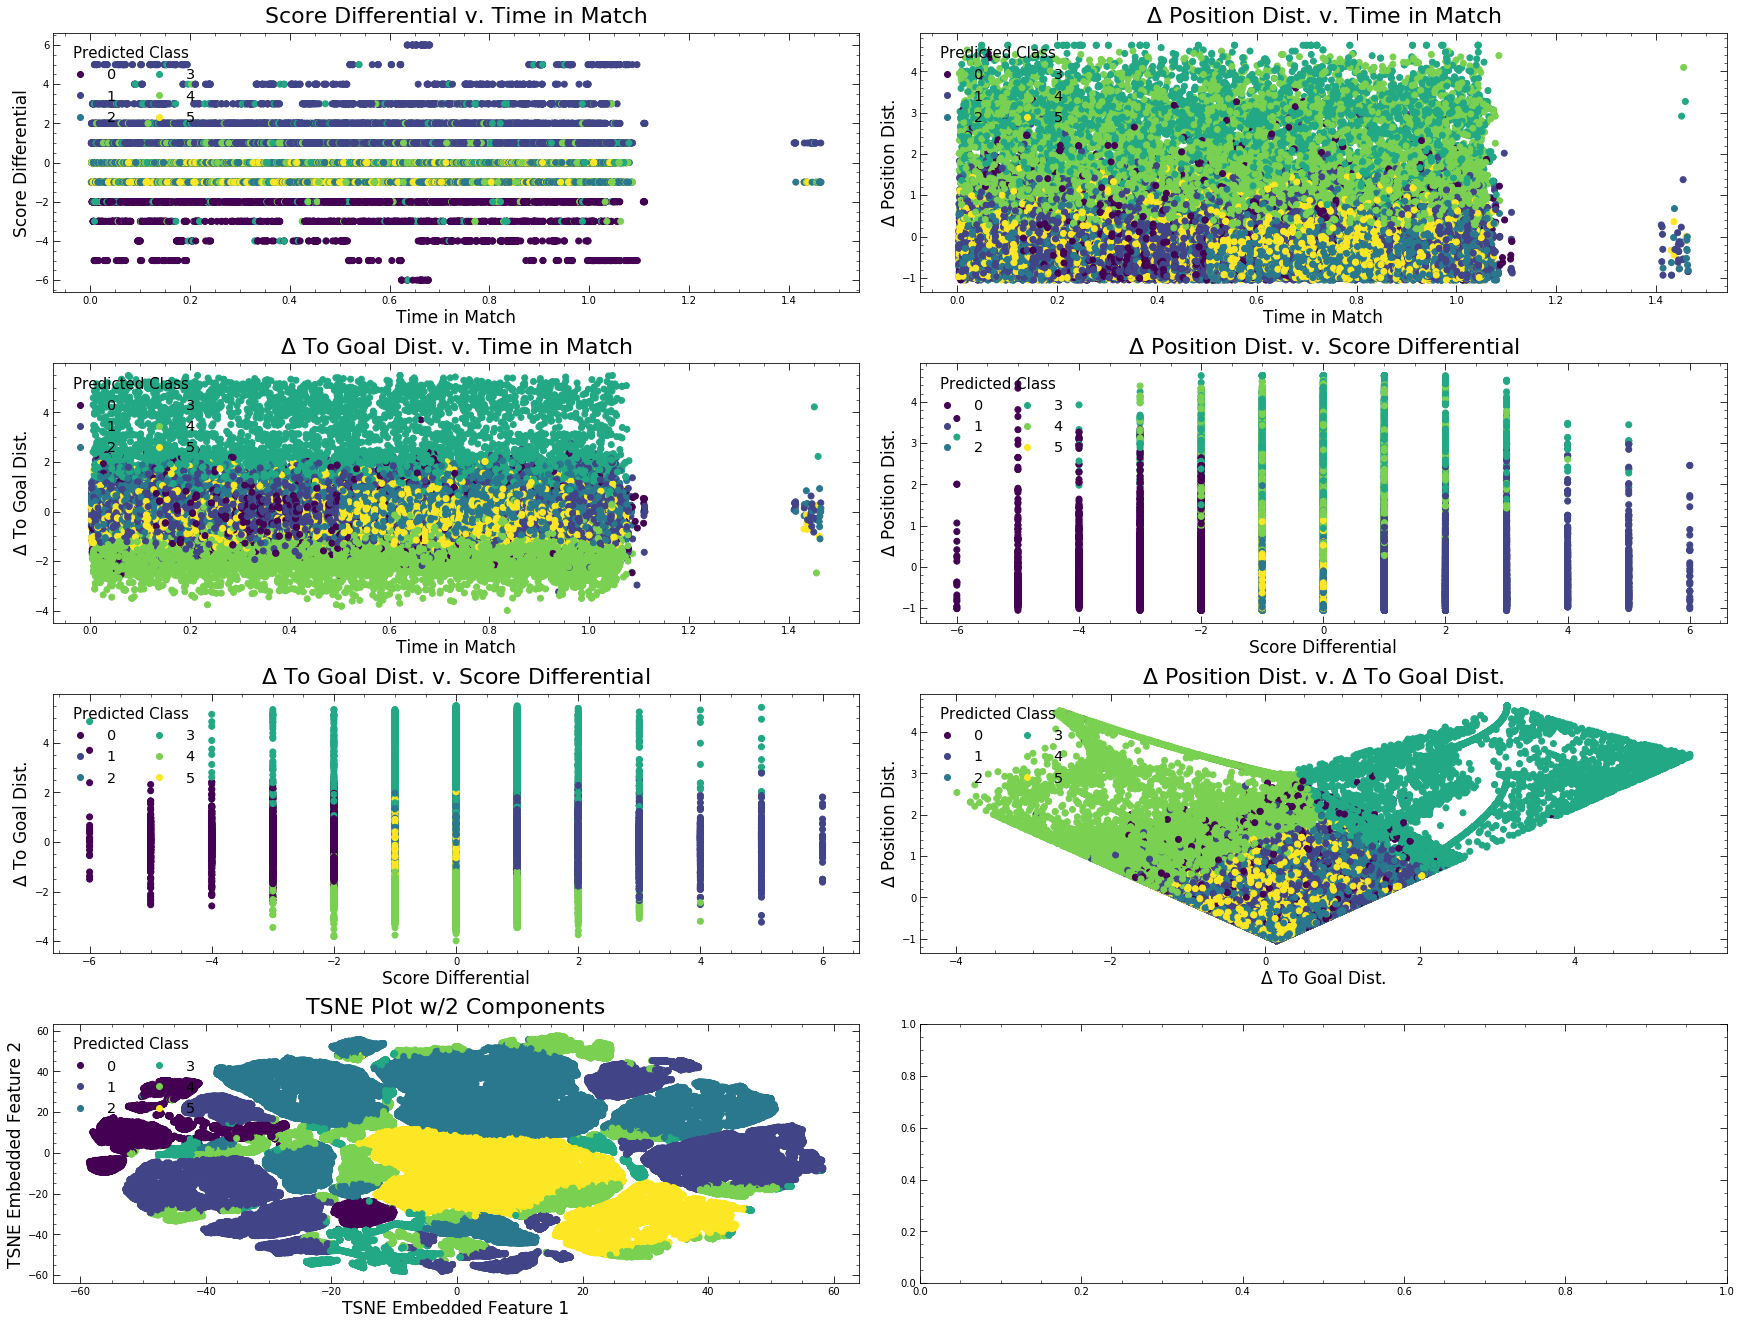

In [29]:
bv.cluster_subplot_generator(full_scaled_feats_arr[:100000:], 
                             scaled_prediction_arr[:100000:],
                             save_plot=True,
                             file_name="events_kmeans_scaled")

### Scaled Sequence-Wide K-Means

In [46]:
agg_scaled_k_means_predictions = best_k_means_agg_scaled.predict(agg_by_mean_scaled_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:442: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

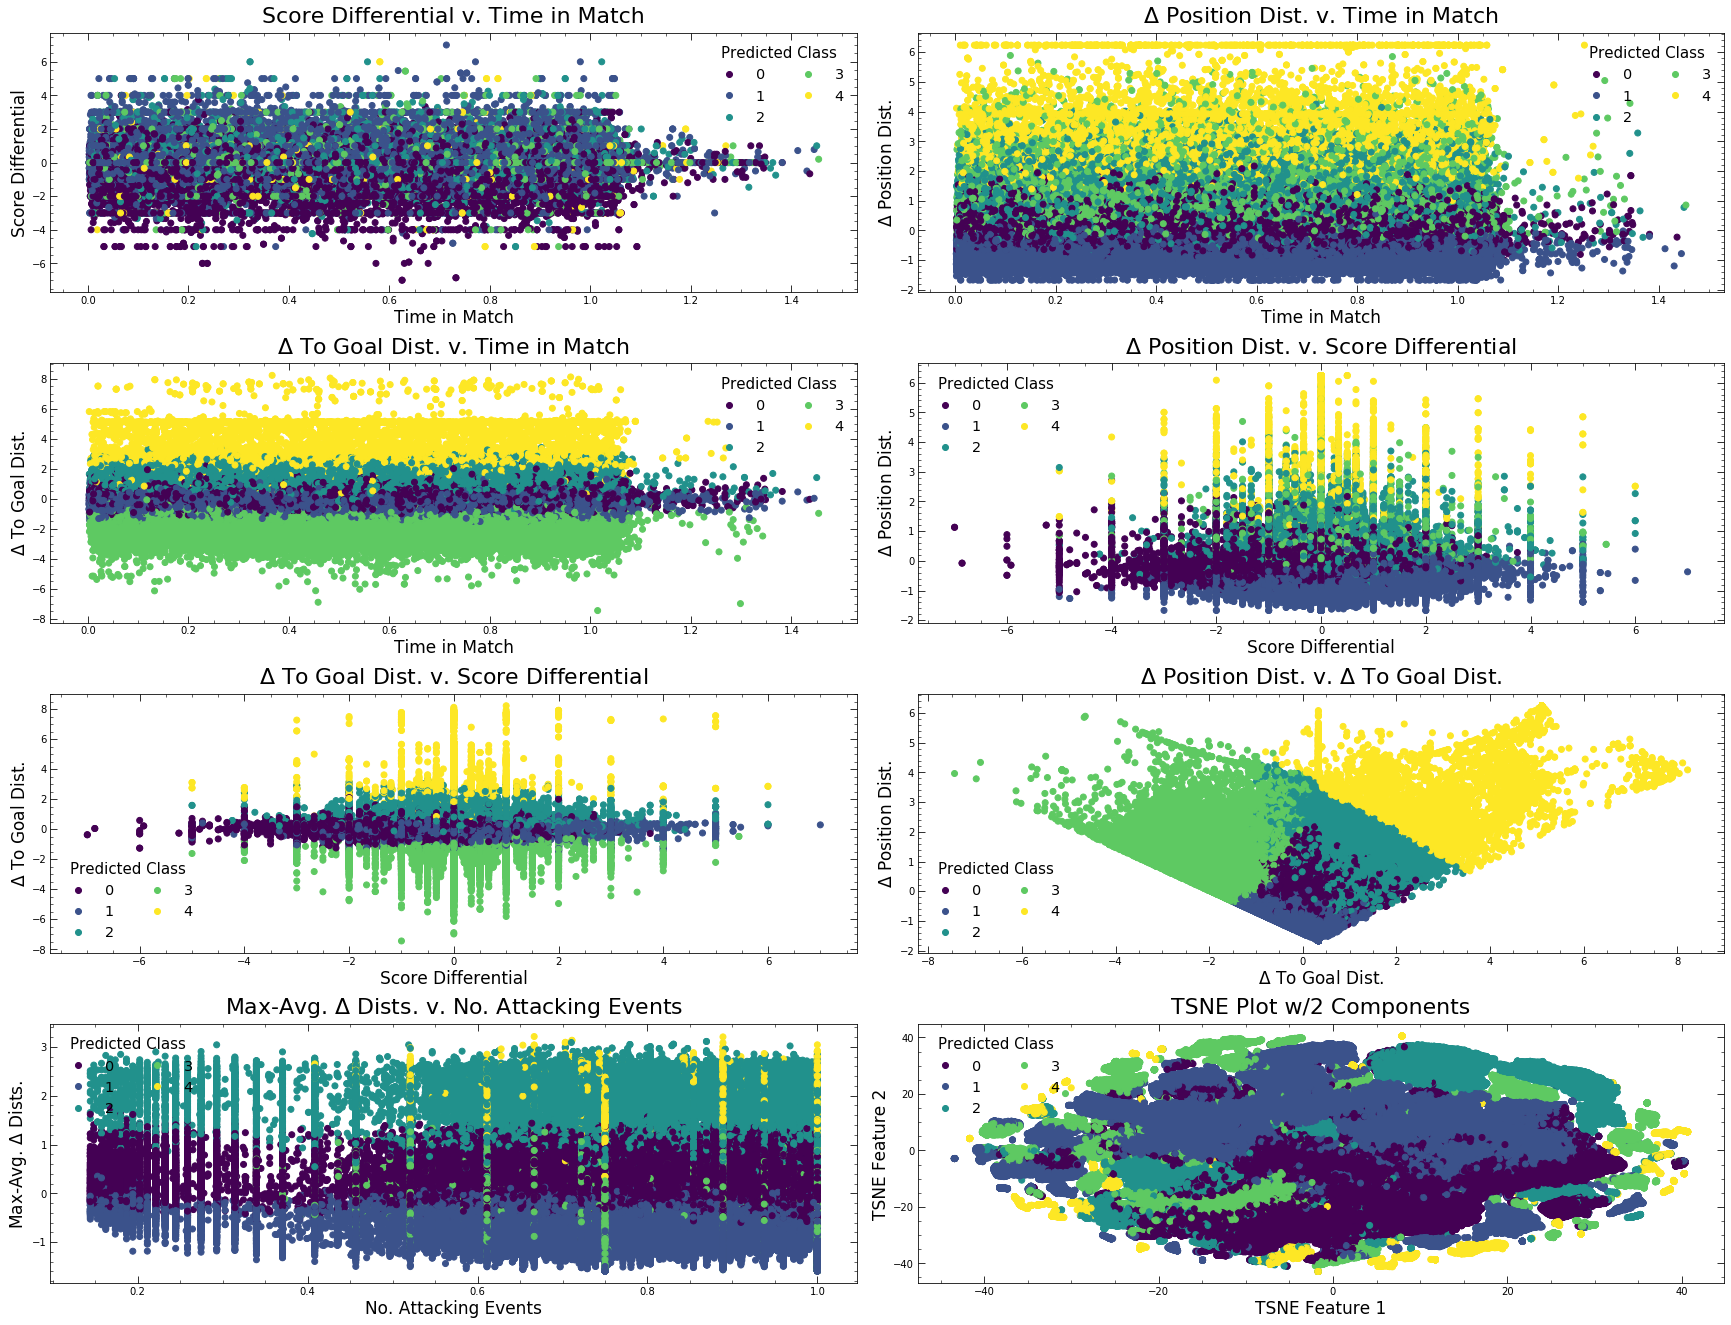

In [58]:
bv.cluster_subplot_generator(agg_by_mean_scaled_arr, 
                             agg_scaled_k_means_predictions,
                             save_plot=True,
                             file_name="seq_kmeans_scaled")

In [47]:
best_k_means_agg_scaled.cluster_centers_

array([[ 0.51758662, -0.17542186,  0.08765778,  0.30912398,  0.37958286,
         0.14400438,  0.00700825,  0.07995708,  0.78883882,  0.18476742],
       [ 0.51646066,  0.08396943,  0.03321538,  0.33841974,  0.42511376,
         0.15988877, -0.7062491 , -0.13465074,  0.81472215, -0.76760523],
       [ 0.5237676 ,  0.0960679 ,  0.09569116,  0.29514464,  0.33458689,
         0.15169932,  0.71166236,  0.82362067,  0.78195483,  1.75793943],
       [ 0.54840101,  0.04292424,  0.23666817,  0.24819441,  0.31578596,
         0.12992958,  0.84156162, -1.5975237 ,  0.78565531, -0.34399075],
       [ 0.54551484,  0.04278579,  0.26824329,  0.29073177,  0.15276798,
         0.13322704,  3.32524066,  3.20097048,  0.82255706,  1.90979097]])

In [48]:
distance_matrix = euclidean_distances(agg_by_mean_scaled_arr, best_k_means_agg_scaled.cluster_centers_)

In [49]:
closest_indicies = np.argmin(distance_matrix, axis=0)

In [50]:
closest_pts = agg_by_mean_scaled_arr[closest_indicies]

In [51]:
closest_pts_df = pd.DataFrame(
    closest_pts, 
    columns=["match_time", "score_diff", "is_goalie", "is_mid", "is_def", 
             "is_foward", "pos_delta_diff", "to_goal_delta_diff",  
             "num_attacking_events", "delta_max_avg"]
)
closest_pts_df

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
0    0.585927         0.0   0.000000  0.333333  0.444444   0.111111   
1    0.602924         0.0   0.000000  0.375000  0.375000   0.250000   
2    0.537095         0.0   0.125000  0.125000  0.500000   0.250000   
3    0.657688         0.0   0.250000  0.250000  0.250000   0.000000   
4    0.394893         0.0   0.333333  0.333333  0.333333   0.000000   

   pos_delta_diff  to_goal_delta_diff  num_attacking_events  delta_max_avg  
0       -0.020433            0.118682              0.749603       0.107785  
1       -0.789666           -0.171334              0.794494      -0.789313  
2        0.739008            0.861049              0.794494       1.711701  
3        1.054658           -1.602032              0.937500      -0.383115  
4        3.258643            3.126715              0.888889       2.191550

### Unscaled Sequenec-Wide K-Means

In [140]:
agg_unscaled_k_means_predictions = best_k_means_agg_unscaled.predict(aggregated_by_mean_arr)

/Users/sebgo/Documents/Professional_Development/Sharpest_Minds/Set_Piece_Strategy_Identifier/src/visualizations/basic_viz.py:447: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



<Figure size 432x288 with 0 Axes>

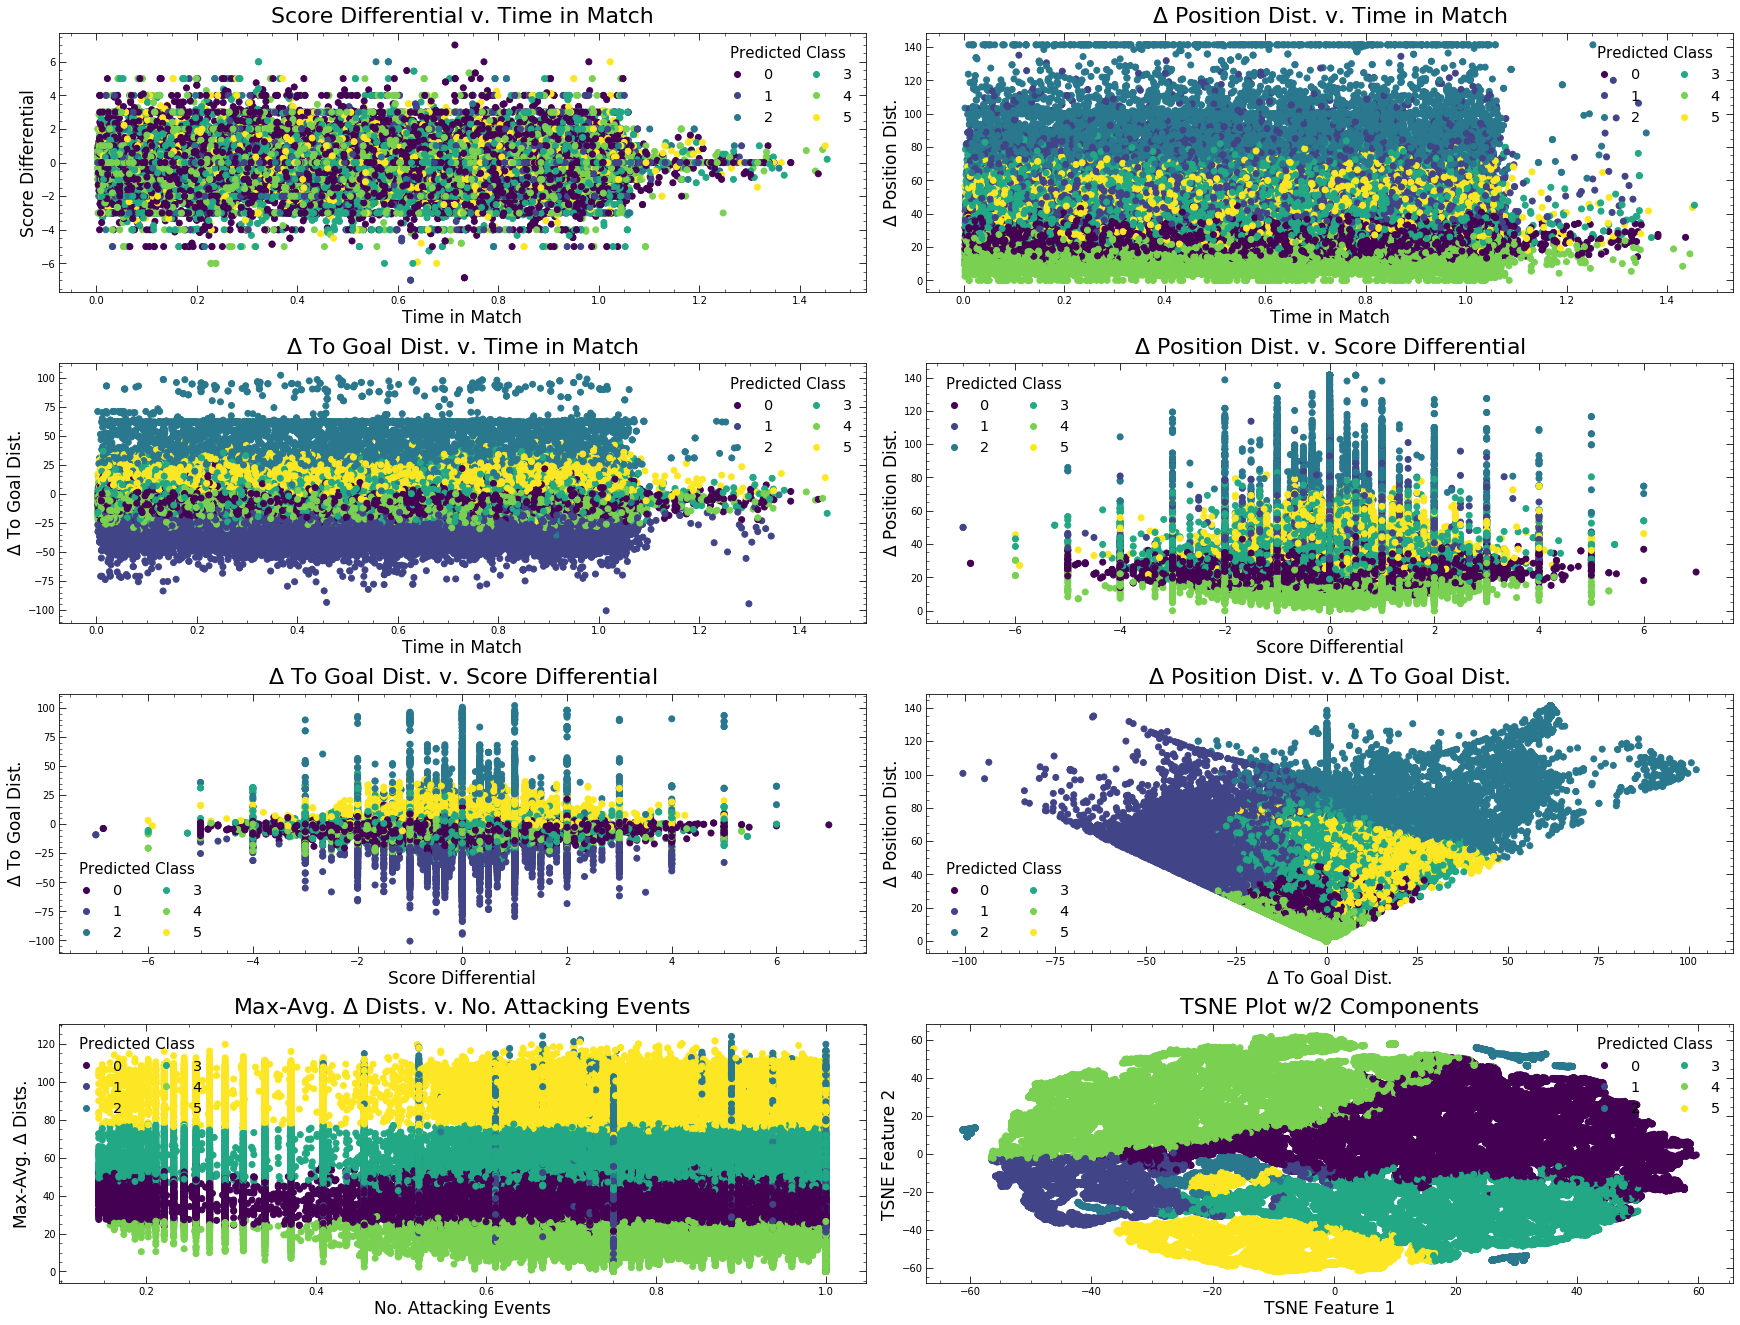

In [146]:
bv.cluster_subplot_generator(aggregated_by_mean_arr, 
                             agg_unscaled_k_means_predictions,
                             save_plot=True,
                             file_name="seq_kmeans_unscaled")

### Scaled Sequence-Wide Mean-Shift

In [ ]:
agg_scaled_mean_shift_predictions = mean_shift_agg_scaled.predict(agg_by_mean_scaled_arr)

In [ ]:
bv.cluster_subplot_generator(agg_by_mean_scaled_arr, 
                             agg_scaled_mean_shift_predictions,
                             save_plot=True,
                             file_name="seq_mean_shift_scaled")

### Unscaled Sequence-Wide Mean-Shift

In [ ]:
agg_unscaled_mean_shift_predictions = mean_shift_agg_unscaled.predict(aggregated_by_mean_arr)

In [ ]:
bv.cluster_subplot_generator(aggregated_by_mean_arr, 
                             agg_unscaled_mean_shift_predictions,
                             save_plot=True,
                             file_name="seq_mean_shift_unscaled")

# Deeper Analysis of Each Cluster

### Scaled Sequence-Wide K-Means

In [52]:
scaled_seq_k_means_df = pd.DataFrame(
    np.hstack([agg_by_mean_scaled_arr, 
               agg_scaled_k_means_predictions.reshape(-1, 1)]),
    columns=["match_time", "score_diff", "is_goalie", "is_mid", "is_def", 
             "is_foward", "pos_delta_diff", "to_goal_delta_diff",  
             "num_attacking_events", "delta_max_avg", "predicted_cluster_id"],
    index=aggregated_by_mean_df.index
)
scaled_seq_k_means_df

match_time  score_diff  is_goalie    is_mid    is_def  is_foward  \
seq_id                                                                     
100       1.412520    0.714286   0.142857  0.142857  0.571429   0.000000   
101       1.430684   -0.500000   0.000000  0.000000  0.500000   0.500000   
102       1.436421   -0.666667   0.000000  0.333333  0.666667   0.000000   
103       1.445103    0.777778   0.000000  0.555556  0.222222   0.111111   
104       1.450213    1.000000   0.000000  0.250000  0.250000   0.500000   
...            ...         ...        ...       ...       ...        ...   
275426    0.921815    0.111111   0.000000  0.333333  0.500000   0.111111   
275427    0.987549    1.000000   0.000000  0.200000  0.200000   0.600000   
275428    0.705332    0.000000   0.333333  0.666667  0.000000   0.000000   
275429    0.806697    0.333333   0.000000  0.166667  0.583333   0.083333   
275430    0.812196    0.000000   0.000000  0.000000  0.500000   0.500000   

        pos_delta_diff  to_goal_delta_diff  num_attacking_events  \
seq_id                                                             
100          -0.613724            0.460742              0.979592   
101          -1.193171           -0.083215              0.937500   
102          -0.223462           -0.032926              0.972222   
103          -0.778276            0.037384              0.987654   
104           0.777798            1.413016              1.000000   
...                ...                 ...                   ...   
275426       -0.264974            0.242210              0.946789   
275427       -0.225275           -0.750145              1.000000   
275428        1.199798            0.811350              0.888889   
275429        0.084178            1.145646              0.803526   
275430        0.116788           -1.667374              0.750000   

        delta_max_avg  predicted_cluster_id  
seq_id                                       
100         -0.850478                   1.0  
101         -1.190912                   1.0  
102         -0.479912                   0.0  
103         -0.846178                   1.0  
104          1.954581                   2.0  
...               ...                   ...  
275426       1.333055                   2.0  
275427      -0.425317                   1.0  
275428       0.756329                   2.0  
275429       2.440341                   2.0  
275430      -0.960954                   3.0  

[275331 rows x 11 columns]

In [61]:
scaled_seq_k_means_df.predicted_cluster_id.value_counts()

1.0    113191
0.0     86141
2.0     37458
3.0     30403
4.0      8138
Name: predicted_cluster_id, dtype: int64

In [56]:
scaled_seq_k_means_df.index.name

'seq_id'

In [54]:
sequences_df.head()

eventId subEventName            tags  playerId  \
0        3    Free Kick  [{'id': 1801}]         0   
1        8  Simple pass  [{'id': 1801}]     50007   
2        8  Simple pass  [{'id': 1801}]     24838   
3        8  Simple pass  [{'id': 1801}]     21415   
4        8  Simple pass  [{'id': 1801}]    284960   

                                  positions  matchId  eventName  teamId  \
0  [{'y': 64, 'x': 35}, {'y': 31, 'x': 38}]  2576040  Free Kick    3219   
1  [{'y': 31, 'x': 38}, {'y': 20, 'x': 38}]  2576040       Pass    3219   
2  [{'y': 20, 'x': 38}, {'y': 50, 'x': 27}]  2576040       Pass    3219   
3  [{'y': 50, 'x': 27}, {'y': 77, 'x': 32}]  2576040       Pass    3219   
4  [{'y': 77, 'x': 32}, {'y': 95, 'x': 36}]  2576040       Pass    3219   

  matchPeriod     eventSec subEventId         id  seq_id  
0          2H  2216.339790         31  198792553     100  
1          2H  2221.716912         85  198792554     100  
2          2H  2225.150837         85  198792555     100  
3          2H  2228.885593         85  198792556     100  
4          2H  2231.951066         85  198792557     100

In [75]:
cluster0_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 0)

cluster1_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 1)

cluster2_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 2)

cluster3_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 3)

cluster4_event_types_df = cbcp.cluster_events_extractor(
    scaled_seq_k_means_df, 4)

In [76]:
cluster0_event_types_df

eventId     eventName  subEventId           subEventName
seq_id                                                          
102           3     Free Kick        31.0              Free Kick
102           8          Pass        85.0            Simple pass
102           8          Pass        85.0            Simple pass
102           8          Pass        85.0            Simple pass
102           8          Pass        85.0            Simple pass
...         ...           ...         ...                    ...
275421        5  Interruption        50.0  Ball out of the field
275422        3     Free Kick        36.0               Throw in
275422        3     Free Kick        34.0              Goal kick
275422        1          Duel        11.0  Ground attacking duel
275422        1          Duel        12.0  Ground defending duel

[731161 rows x 4 columns]

In [86]:
cluster0_event_types_counts = cbcp.cluster_counts(cluster0_event_types_df)
cluster1_event_types_counts = cbcp.cluster_counts(cluster1_event_types_df)
cluster2_event_types_counts = cbcp.cluster_counts(cluster2_event_types_df)
cluster3_event_types_counts = cbcp.cluster_counts(cluster3_event_types_df)
cluster4_event_types_counts = cbcp.cluster_counts(cluster4_event_types_df)

In [88]:
cluster3_event_types_counts[0]

event_name  event_count  nevent_count
0                     Duel        17242      0.198031
1                     Foul          198      0.002274
2                Free Kick        37197      0.427223
3  Goalkeeper leaving line          223      0.002561
4             Interruption         3288      0.037764
5                  Offside          133      0.001528
6       Others on the ball         6185      0.071037
7                     Pass        22328      0.256446
8             Save attempt          158      0.001815
9                     Shot          115      0.001321

In [87]:
cluster3_event_types_counts[1]

sub_event_name  sub_event_count  nsub_event_count
0              Acceleration              224          0.002577
1                  Air duel            11720          0.134815
2     Ball out of the field             3281          0.037741
3                 Clearance             4352          0.050061
4                    Corner             4844          0.055720
5                     Cross             1100          0.012653
6                      Foul              178          0.002048
7                 Free Kick             9606          0.110498
8           Free kick cross             2448          0.028159
9            Free kick shot              183          0.002105
10                Goal kick            11883          0.136690
11  Goalkeeper leaving line              223          0.002565
12    Ground attacking duel             1318          0.015161
13    Ground defending duel             1541          0.017726
14   Ground loose ball duel             2663          0.030632
15                Hand foul               14          0.000161
16                Hand pass              185          0.002128
17                Head pass             5696          0.065521
18                High pass             4701          0.054076
19           Late card foul                0          0.000000
20                   Launch             2848          0.032760
21                  Offside                0          0.000000
22         Out of game foul                2          0.000023
23                  Penalty               57          0.000656
24                  Protest                3          0.000035
25                 Reflexes               41          0.000472
26             Save attempt              117          0.001346
27                     Shot              115          0.001323
28              Simple pass             7381          0.084903
29               Simulation                0          0.000000
30               Smart pass              417          0.004797
31                 Throw in             8176          0.094048
32           Time lost foul                1          0.000012
33                    Touch             1609          0.018508
34             Violent Foul                0          0.000000
35                  Whistle                7          0.000081

### Event Type Histogram For Each Cluster

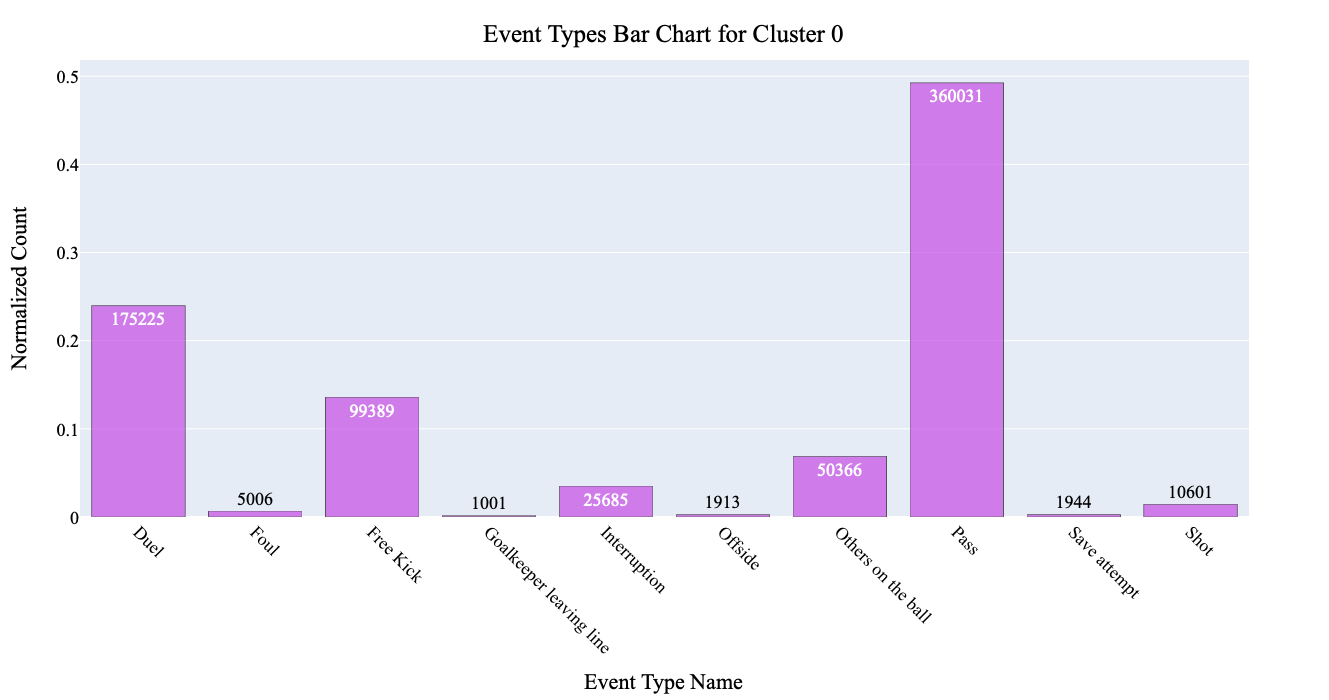

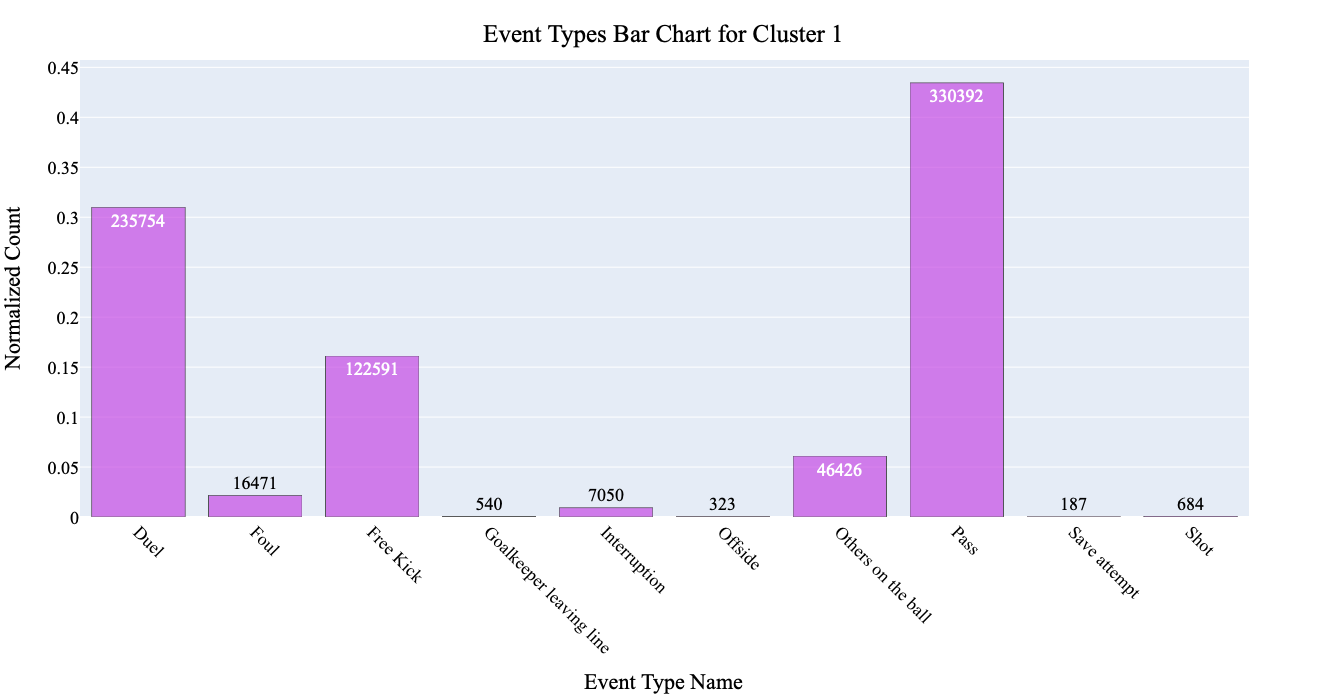

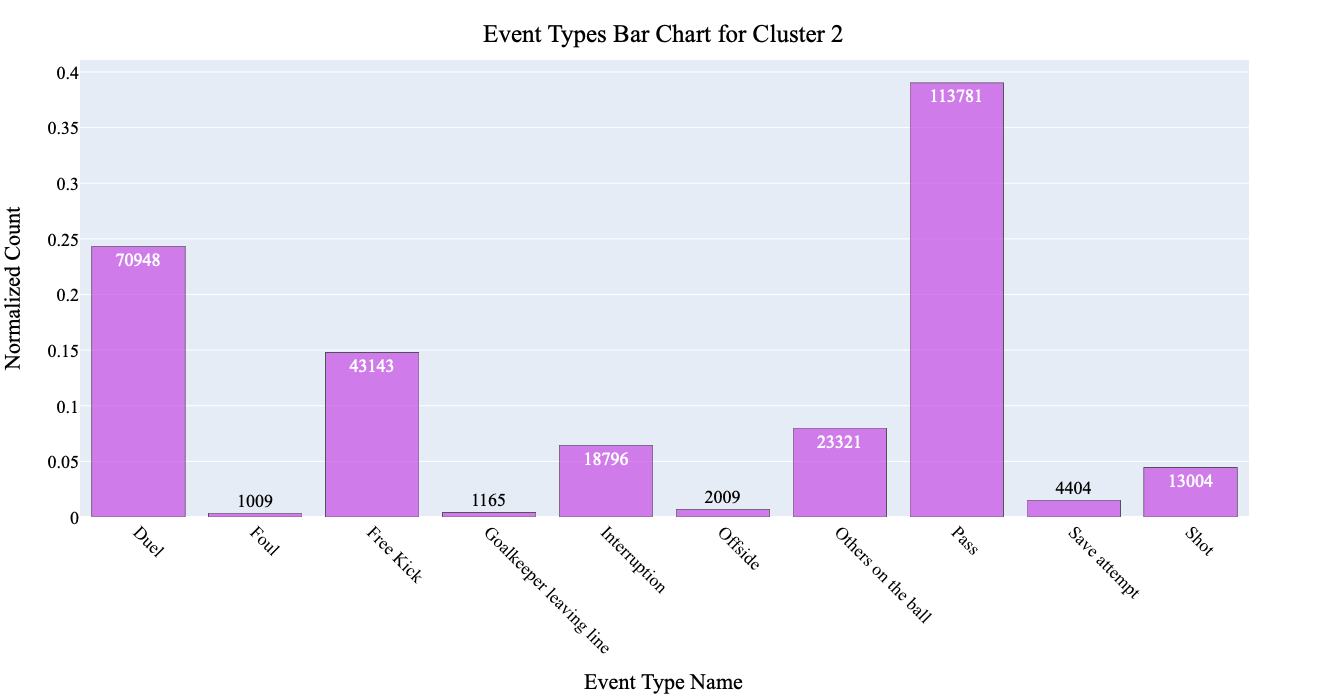

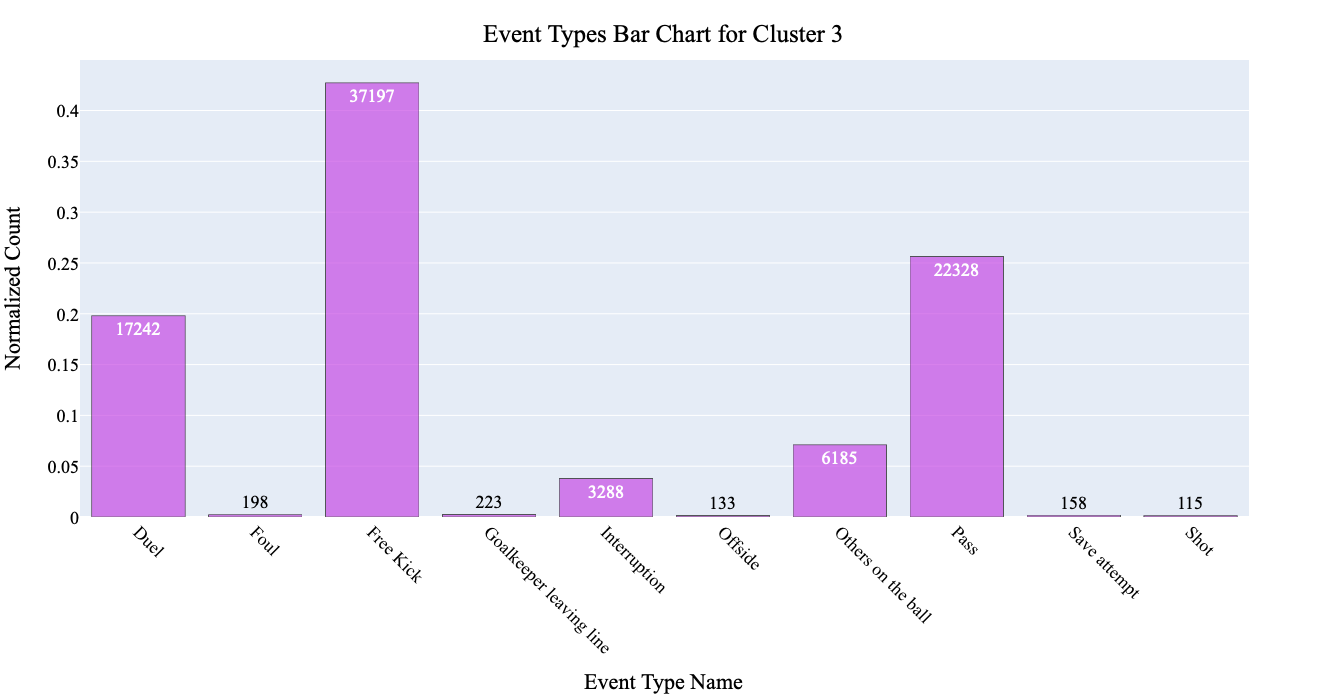

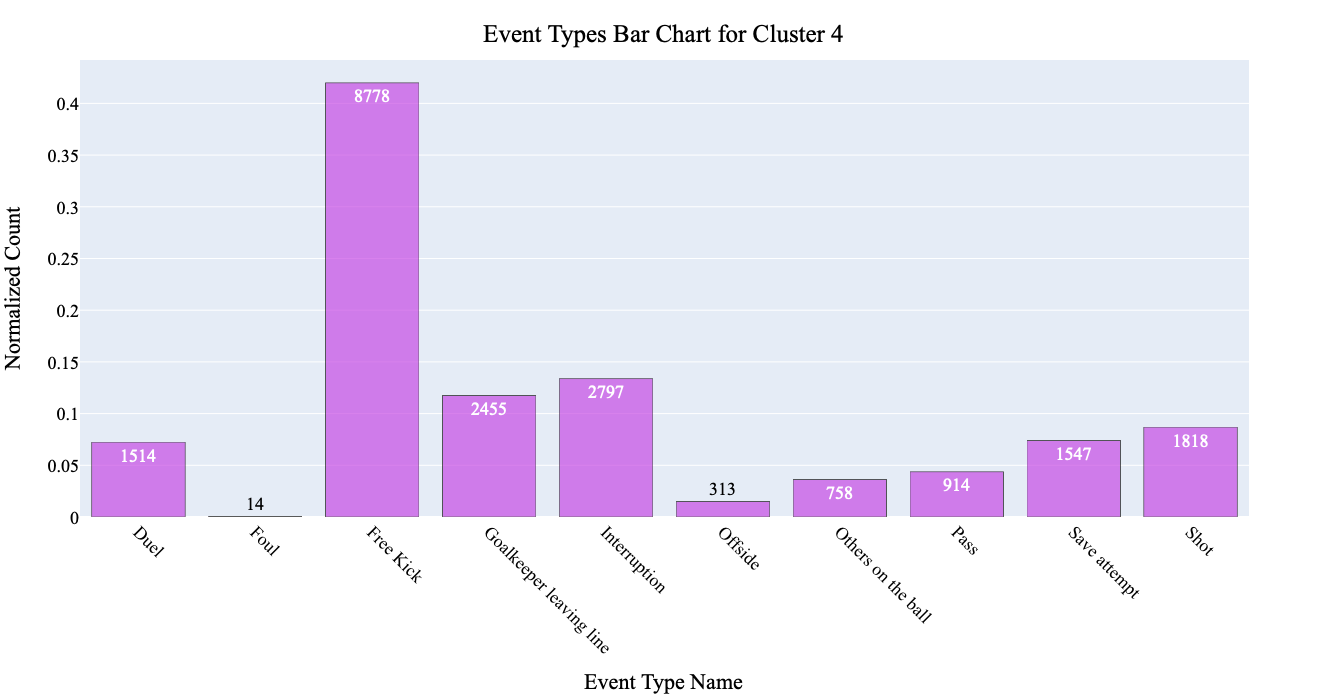

In [93]:
# first cluster
cluster_0_bar_obj = bv.plotly_bar_chart(
    cluster0_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=0
)
cluster_0_bar_obj.show()
print("", end="\n\n")

# second cluster
cluster_1_bar_obj = bv.plotly_bar_chart(
    cluster1_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=1
)
cluster_1_bar_obj.show()
print("", end="\n\n")

# third cluster
cluster_2_bar_obj = bv.plotly_bar_chart(
    cluster2_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=2
)
cluster_2_bar_obj.show()
print("", end="\n\n")

# fourth cluster
cluster_3_bar_obj = bv.plotly_bar_chart(
    cluster3_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=3
)
cluster_3_bar_obj.show()
print("", end="\n\n")

# fifth cluster
cluster_4_bar_obj = bv.plotly_bar_chart(
    cluster4_event_types_counts[0], 
    {"x": "event_name", "y":"nevent_count", "text": "event_count"},
    cluster_id=4
)
cluster_4_bar_obj.show()
print("", end="\n\n")

### Sub Event Type Histogram For Each Cluster

In [96]:
cluster0_event_types_counts[1].head()

sub_event_name  sub_event_count  nsub_event_count
0           Acceleration             2621          0.003594
1               Air duel            52786          0.072384
2  Ball out of the field            25552          0.035039
3              Clearance            14023          0.019229
4                 Corner             9968          0.013669

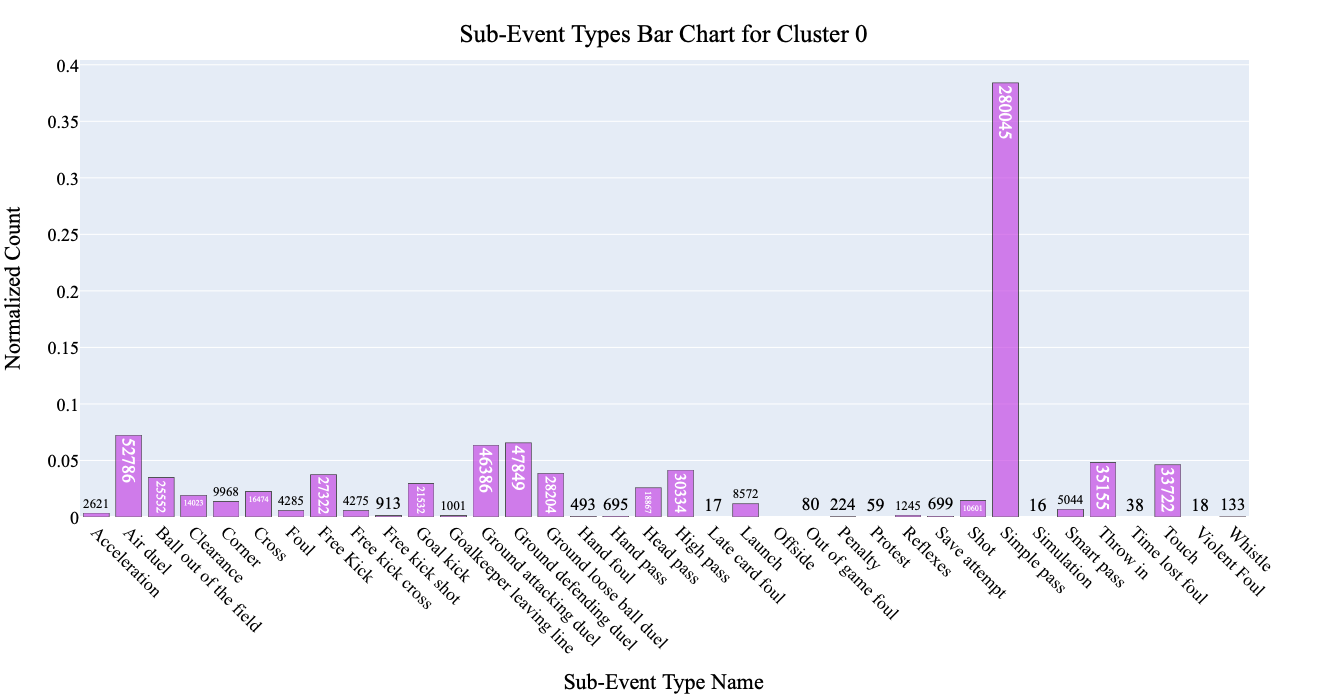

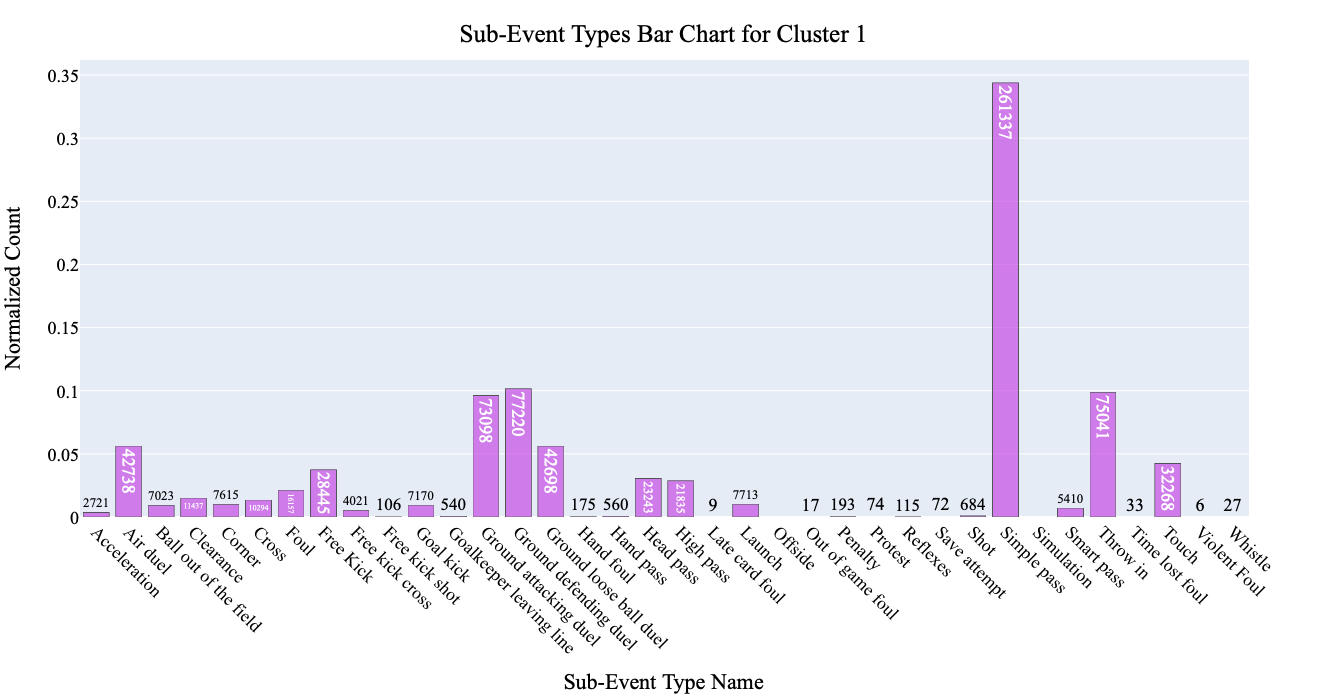

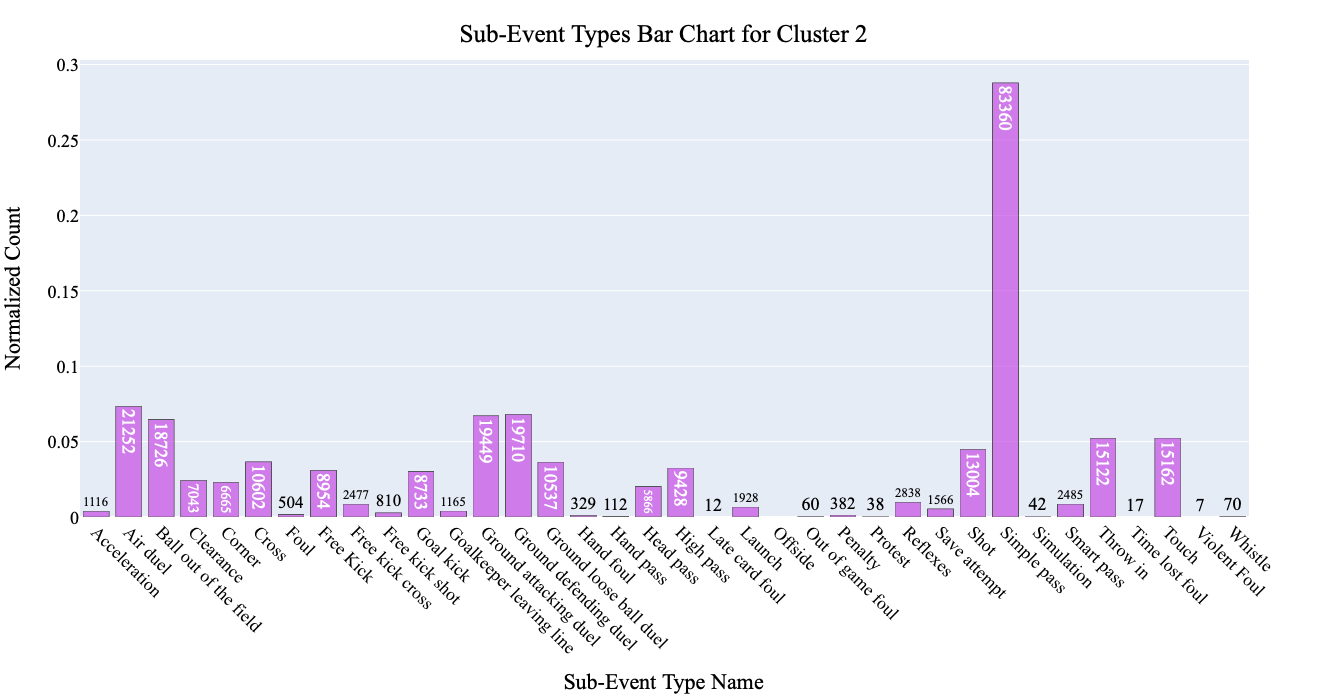

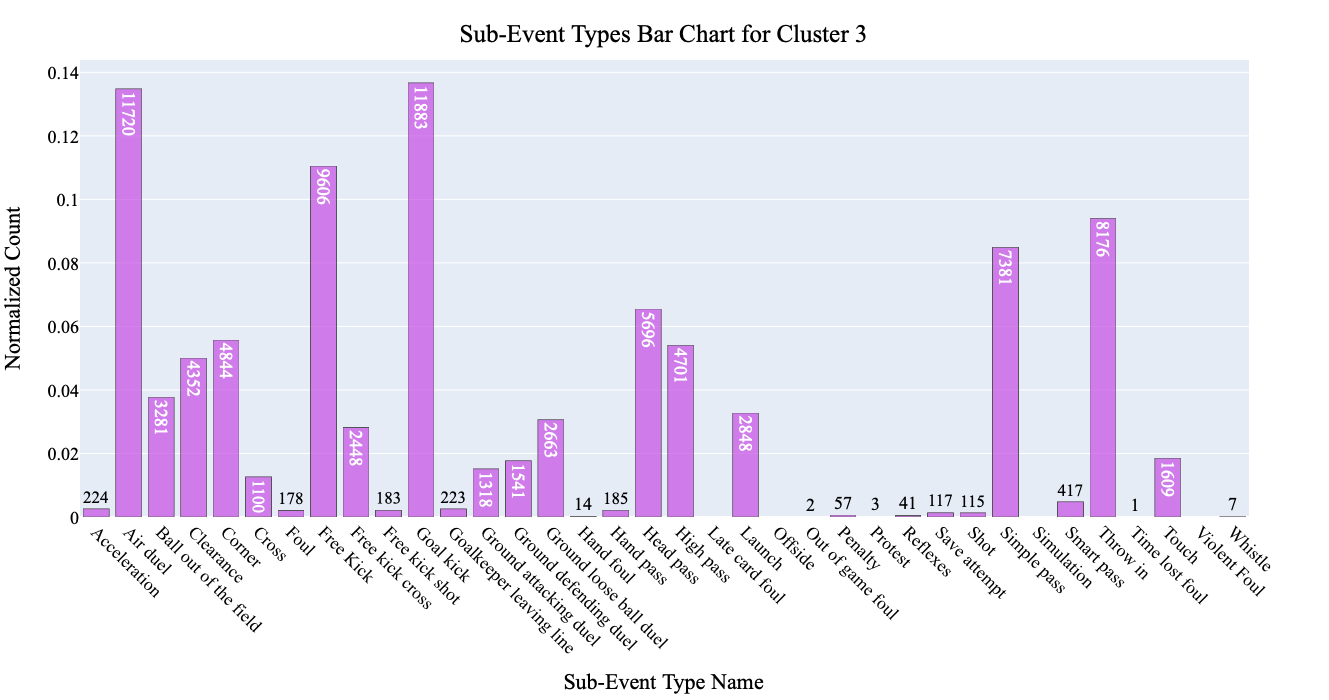

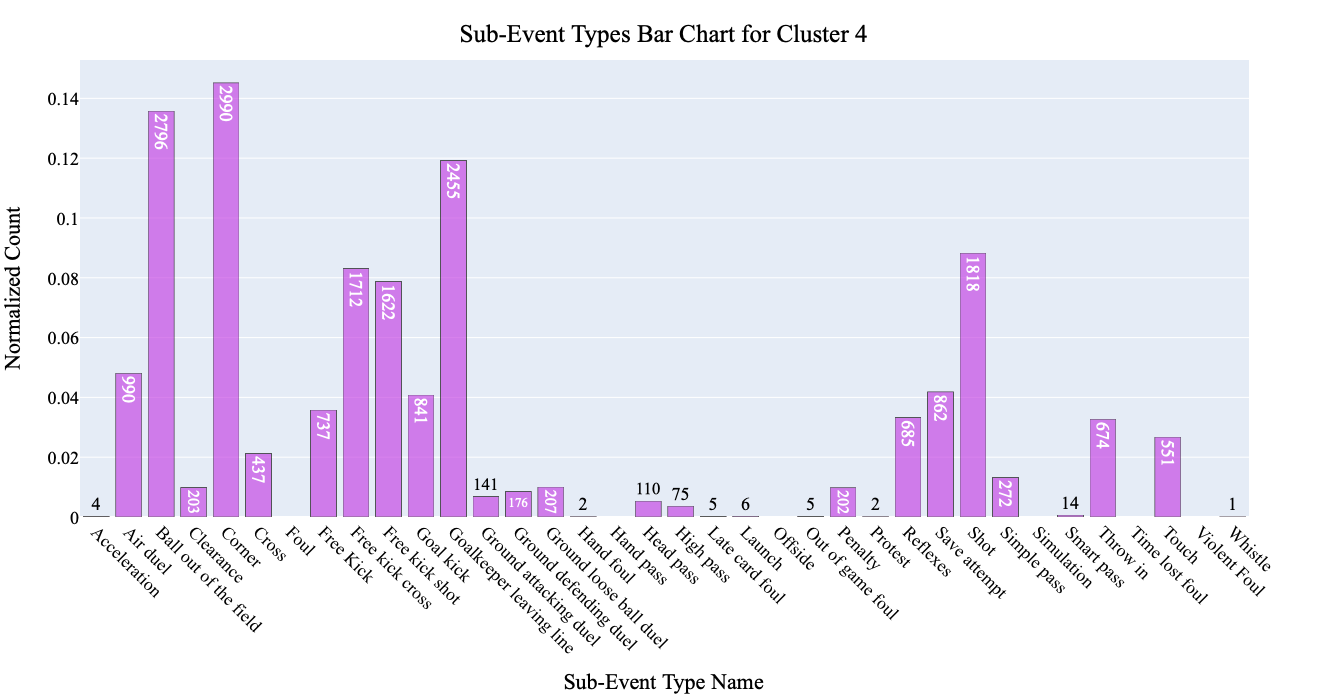

<Figure size 432x288 with 0 Axes>

In [98]:
# first cluster
cluster_0_sub_bar_obj = bv.plotly_bar_chart(
    cluster0_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=0
)
cluster_0_sub_bar_obj.show()
print("", end="\n\n")

# second cluster
cluster_1_sub_bar_obj = bv.plotly_bar_chart(
    cluster1_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=1
)
cluster_1_sub_bar_obj.show()
print("", end="\n\n")

# third cluster
cluster_2_sub_bar_obj = bv.plotly_bar_chart(
    cluster2_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=2
)
cluster_2_sub_bar_obj.show()
print("", end="\n\n")

# fourth cluster
cluster_3_sub_bar_obj = bv.plotly_bar_chart(
    cluster3_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=3
)
cluster_3_sub_bar_obj.show()
print("", end="\n\n")

# fifth cluster
cluster_4_sub_bar_obj = bv.plotly_bar_chart(
    cluster4_event_types_counts[1], 
    {"x": "sub_event_name", "y":"nsub_event_count", "text": "sub_event_count"},
    cluster_id=4
)
cluster_4_sub_bar_obj.show()
print("", end="\n\n")